In [46]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
import matplotlib.pyplot as plt

from helpr.physics.api import CrackEvolutionAnalysis
from helpr.utilities.unit_conversion import convert_psi_to_mpa, convert_in_to_m
from helpr.utilities.plots import (plot_cycle_life_cdfs, plot_cycle_life_pdfs, plot_cycle_life_criteria_scatter,
                                   plot_pipe_life_ensemble, failure_assessment_diagram_equation)
from probabilistic.capabilities.uncertainty_definitions import (UniformDistribution, TruncatedNormalDistribution,
                                                                TruncatedLognormalDistribution, DeterministicCharacterization)
from probabilistic.capabilities.plotting import plot_sample_histogram

In [48]:
# # turn warnings back on for general use
# import warnings
# warnings.filterwarnings('ignore')

## **Probabilistic Evaluation for Single Pipe Lifetime**

#### **Problem Specification**

- **Geometry**

In [49]:
pipe_outer_diameter = DeterministicCharacterization(name='outer_diameter',
                                                    value=convert_in_to_m(36))  # pipe outer diameter, m
wall_thickness = DeterministicCharacterization(name='wall_thickness',
                                               value=convert_in_to_m(0.406))  # pipe wall thickness, m

- **Material Properties**

In [50]:
yield_strength = DeterministicCharacterization(name='yield_strength',
                                               value=convert_psi_to_mpa(52_000))  # material yield strength, psi
fracture_resistance = DeterministicCharacterization(name='fracture_resistance',
                                                    value=55)  # fracture resistance (toughness), MPa m1/2

- **Operating Conditions**

In [51]:
# maximum pressure during oscillation, MPa
max_pressure = TruncatedNormalDistribution(name='max_pressure',
                                  uncertainty_type='aleatory',
                                  nominal_value=convert_psi_to_mpa(840),
                                  mean=convert_psi_to_mpa(850),
                                  std_deviation=convert_psi_to_mpa(20),
                                  lower_bound=convert_psi_to_mpa(850)-3*convert_psi_to_mpa(20),
                                  upper_bound=convert_psi_to_mpa(850)+3*convert_psi_to_mpa(20))
# minimum pressure during oscillation, MPa
min_pressure = TruncatedNormalDistribution(name='min_pressure',
                                  uncertainty_type='aleatory',
                                  nominal_value=convert_psi_to_mpa(638),
                                  mean=convert_psi_to_mpa(638),
                                  std_deviation=convert_psi_to_mpa(20),
                                  lower_bound=convert_psi_to_mpa(638)-3*convert_psi_to_mpa(20),
                                  upper_bound=convert_psi_to_mpa(638)+3*convert_psi_to_mpa(20))
temperature = UniformDistribution(name='temperature',
                                  uncertainty_type='aleatory',
                                  nominal_value=293,
                                  upper_bound=300,
                                  lower_bound=285)  # gas blend temperature variation, K
volume_fraction_h2 = UniformDistribution(name='volume_fraction_h2',
                                         uncertainty_type='aleatory',
                                         nominal_value=0.1,
                                         upper_bound=0.2,
                                         lower_bound=0)  # % volume fraction H2 in natural gas blend, fraction

- **Initial Crack Dimensions**

In [52]:
flaw_depth = TruncatedLognormalDistribution(name='flaw_depth',
                                            uncertainty_type='aleatory',
                                            nominal_value=25,
                                            mu=3.2,
                                            sigma=.17,
                                            upper_bound=80,
                                            lower_bound=0.001) # initial flaw depth, % wall thickness
flaw_length = DeterministicCharacterization(name='flaw_length',
                                            value=convert_in_to_m(1.575))  # length of initial crack/flaw, m

- **Quantity of Interest (QoI)**

In [53]:
plotted_variable = 'Cycles to a(crit)'

- **Probabilistic Settings**

In [54]:
sample_type = 'lhs'
sample_size = 1_000

- **Physics Modeling Choices**

In [55]:
stress_intensity_method = 'api'  # Stress intensity factor method used
surface='inside'

####  **Analysis**
- **Using LHS sampling of uncertain variables**

In [56]:
analysis = CrackEvolutionAnalysis(outer_diameter=pipe_outer_diameter,
                                  wall_thickness=wall_thickness,
                                  flaw_depth=flaw_depth,
                                  max_pressure=max_pressure,
                                  min_pressure=min_pressure,
                                  temperature=temperature,
                                  volume_fraction_h2=volume_fraction_h2,
                                  yield_strength=yield_strength,
                                  fracture_resistance=fracture_resistance,
                                  flaw_length=flaw_length,
                                  aleatory_samples=sample_size,
                                  sample_type=sample_type,
                                  stress_intensity_method=stress_intensity_method,
                                  surface=surface)
analysis.perform_study()                                          

/Users/bbschro/Development/helpr/src/helpr/physics/stress_state.py:129: UserWarning: Stress state exceeding 72% SMYS
  wr.warn('Stress state exceeding 72% SMYS', UserWarning)


####  **Postprocessing**

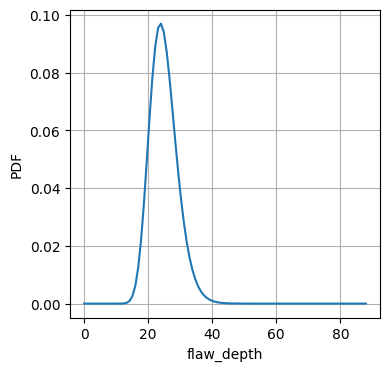

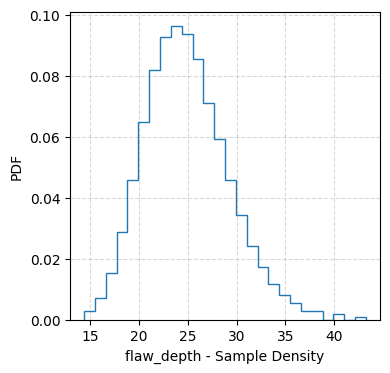

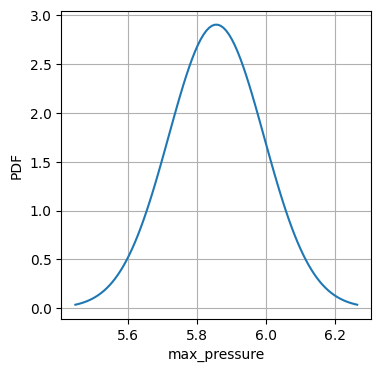

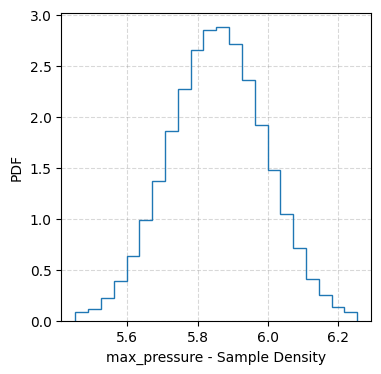

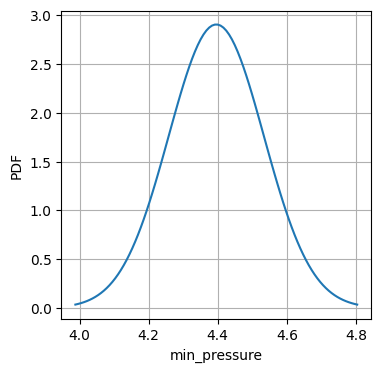

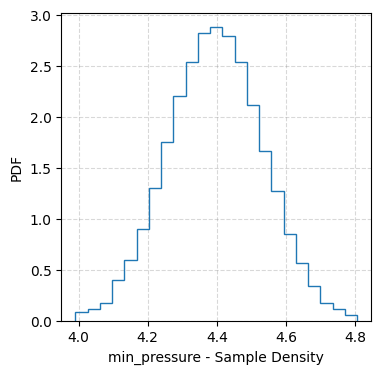

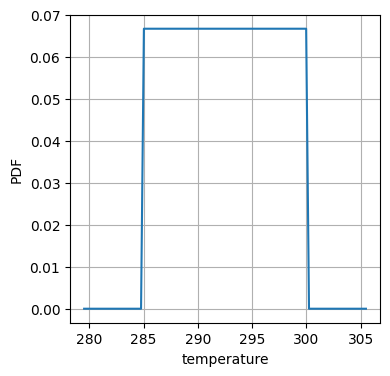

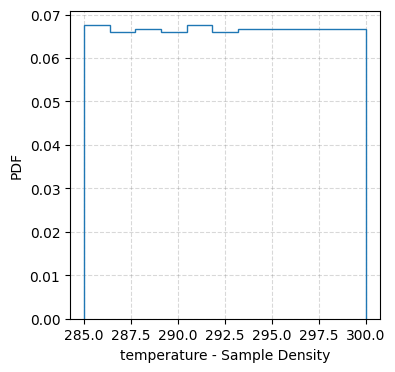

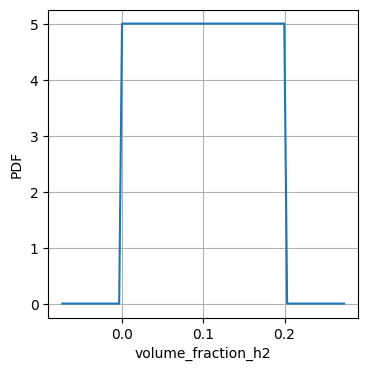

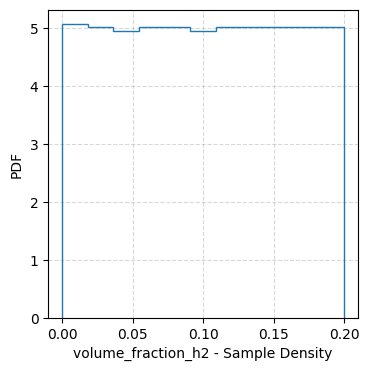

In [57]:
for parameter in analysis.uncertain_parameters:

    analysis.input_parameters[parameter].plot_distribution()

    plot_sample_histogram(analysis.sampling_input_parameter_values[parameter],
                          f'{parameter} - Sample Density',
                          density=True,
                          histtype='step')

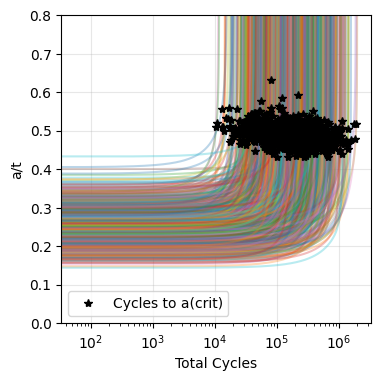

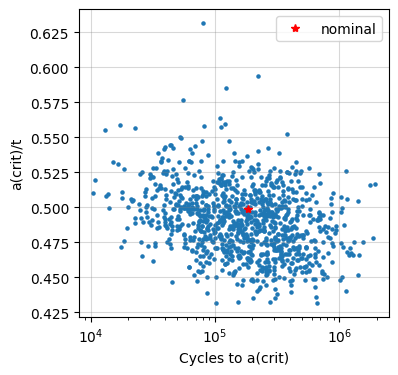

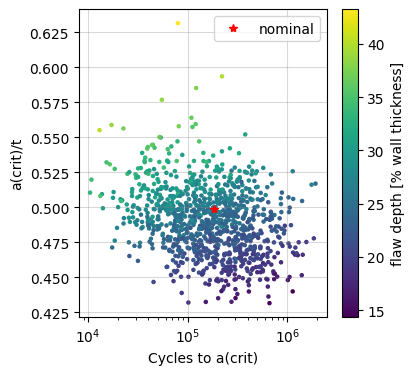

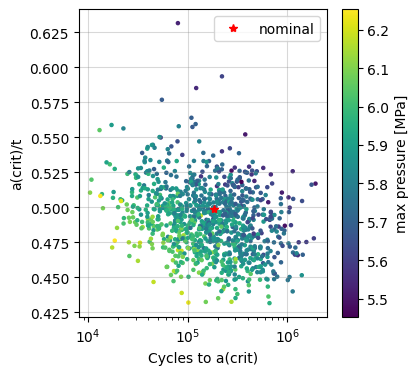

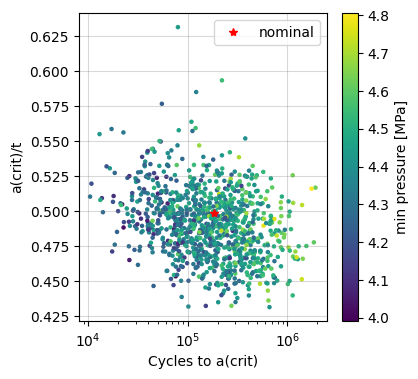

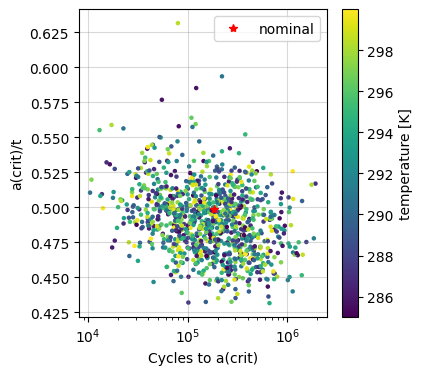

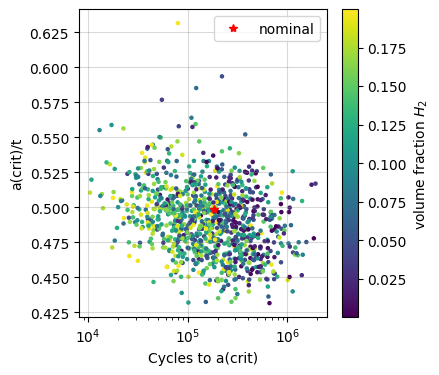

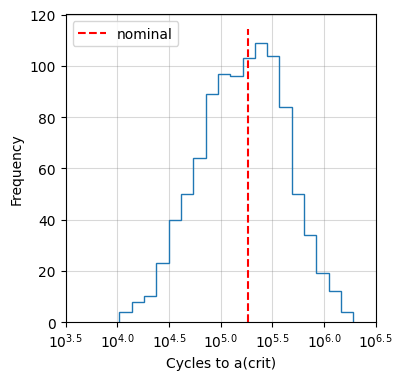

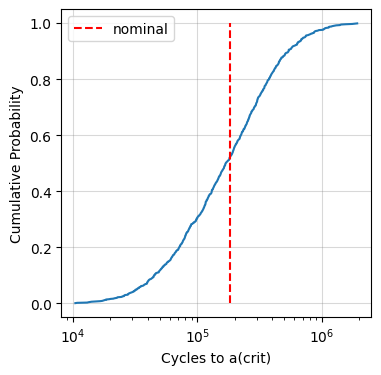

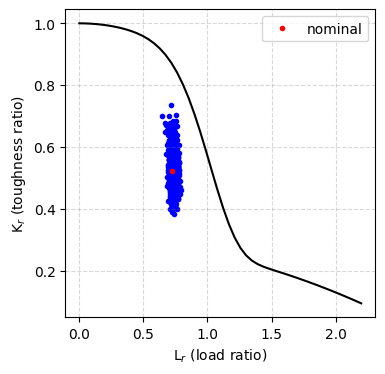

In [58]:
analysis.generate_probabilistic_results_plots(plotted_variable=plotted_variable)
_, _ = analysis.assemble_failure_assessment_diagram()

In [59]:
analysis.save_results()

'Results/date_04_12_2024_time_20_30/'